# Course: Application of AI, Data Science and Machine Learning
# Lab 10-Part2 :Buidling a deep learning model for voice recognition.

# Q1. Read 'harvard.wav' and extract features for example, Zero Crossing Rate,  spectral centroid from it?

Populating the interactive namespace from numpy and matplotlib


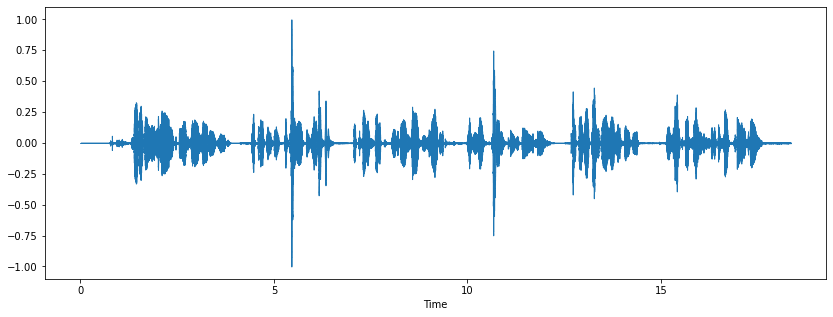

In [ ]:
import librosa.display
%pylab inline
import matplotlib.pyplot as plt
audio_path = 'harvard.wav'
x , sr = librosa.load(audio_path)
#Plot the signal:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)

#### ## Zooming in and find Zero Crossing Rate

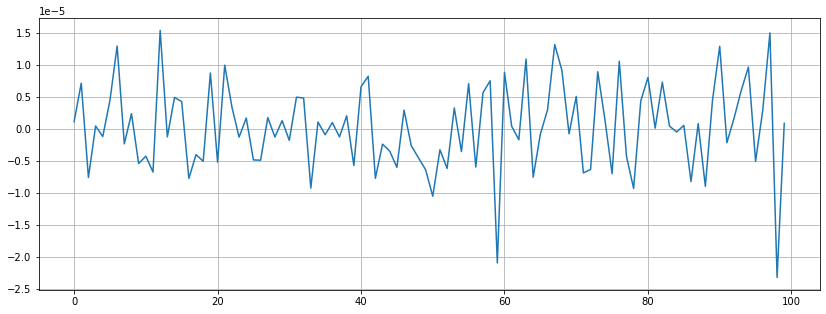

In [ ]:
# Zooming in
n0 = 9000
n1 = 9100
plt.figure(figsize=(14, 5))
plt.plot(x[n0:n1])
plt.grid()

In [ ]:
zero_crossings = librosa.zero_crossings(x[n0:n1], pad=False)
print(sum(zero_crossings))

64


### spectral centroid -- centre of mass -- weighted mean of the frequencies present in the sound

<ipython-input-12-b7712e1cae6f>:3: FutureWarning: Pass y=[ 5.2405644e-06 -1.1075833e-05 -8.1640655e-06 ... -2.0733899e-03
 -1.7548881e-03 -1.8626769e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]


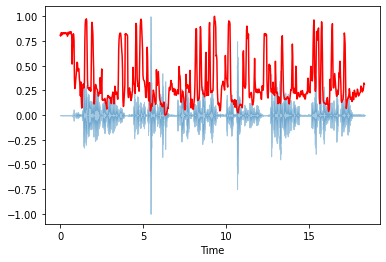

In [ ]:
#spectral centroid -- centre of mass -- weighted mean of the frequencies present in the sound
import sklearn
spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
spectral_centroids.shape
# Computing the time variable for visualization
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)
#Plotting the Spectral Centroid along the waveform
librosa.display.waveshow(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')

## Q2.  Build a deep learning model for voice recognition? Use data in folder 'short-data2'?

In [ ]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
DATASET_PATH = 'short-data2'
data_dir = pathlib.Path(DATASET_PATH)

In [ ]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['happy2' 'dog2' 'go2']


In [ ]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 85
Number of examples per label: 32
Example file tensor: tf.Tensor(b'short-data2/happy2/0f7205ef_nohash_0.wav', shape=(), dtype=string)


In [ ]:
#Split filenames into training, validation and test sets using a 80:10:10 ratio, respectively:


train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 85
Validation set size 0
Test set size 85


In [ ]:
test_file = tf.io.read_file(DATASET_PATH+'/dog2/0a7c2a8d_nohash_0.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([16000, 1])

In [ ]:
#Now, let's define a function that preprocesses the dataset's raw WAV audio files into audio tensors:


def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
  return tf.squeeze(audio, axis=-1)

In [ ]:
'''
Define a function that creates labels using the parent directories for each file:

Split the file paths into tf.RaggedTensors (tensors with ragged dimensions—with slices 
that may have different lengths).
'''
def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return parts[-2]

In [ ]:
'''
Define another helper function—get_waveform_and_label—that puts it all together:

The input is the WAV audio filename.
The output is a tuple containing the audio and label tensors ready for supervised learning
'''
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [ ]:
'''
Build the training set to extract the audio-label pairs:

Create a tf.data.Dataset with Dataset.from_tensor_slices and Dataset.map, using get_waveform_and_label 
defined earlier. You'll build the validation and test sets using a similar procedure later on.
'''
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

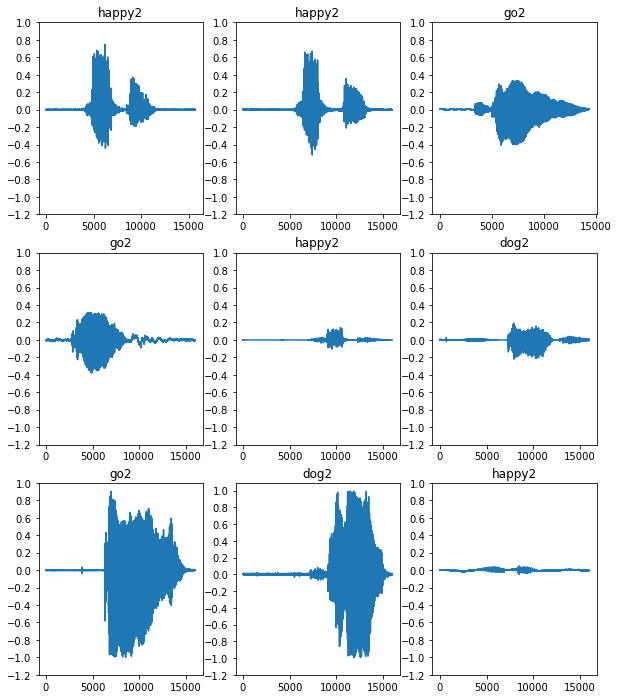

In [ ]:
#Let's plot a few audio waveforms:


rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [ ]:
#Convert waveforms to spectrograms
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [ ]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: happy2
Waveform shape: (15702,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

<ipython-input-29-512707cb7e95>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


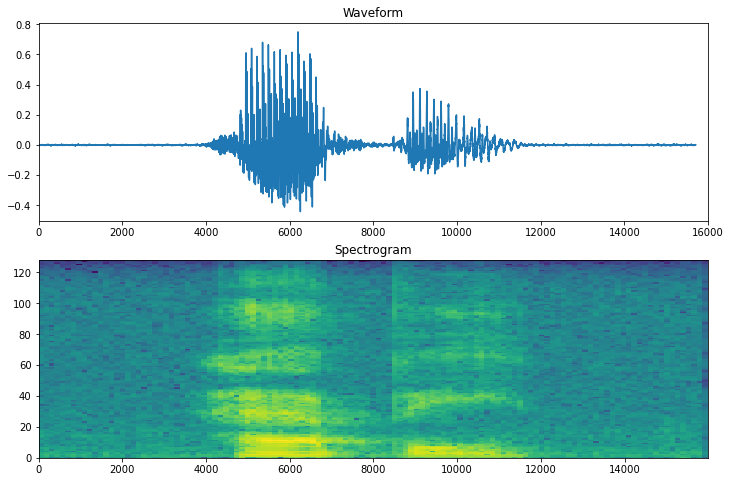

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [ ]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [ ]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

<ipython-input-29-512707cb7e95>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


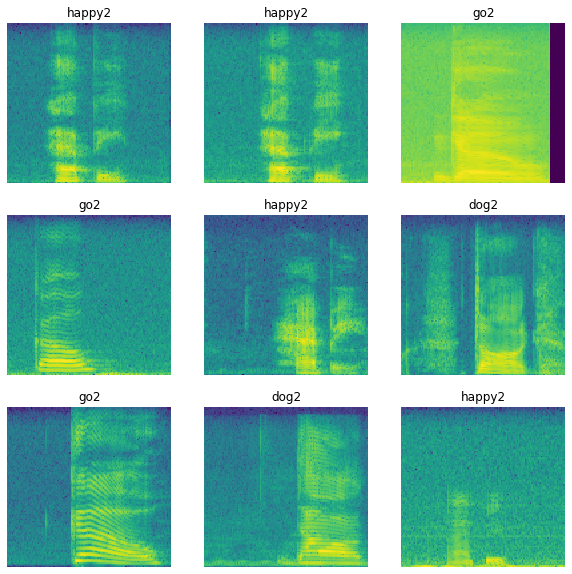

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

In [ ]:
#Build and train the model
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [ ]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [ ]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [ ]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [ ]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
2/2 [==============================] - 2s 518ms/step - loss: 1.1401 - accuracy: 0.4000
Epoch 2/10
2/2 [==============================] - 1s 855ms/step - loss: 0.9473 - accuracy: 0.5647
Epoch 3/10
2/2 [==============================] - 1s 966ms/step - loss: 0.8829 - accuracy: 0.6000
Epoch 4/10
2/2 [==============================] - 2s 1s/step - loss: 0.7877 - accuracy: 0.6353
Epoch 5/10
2/2 [==============================] - 1s 863ms/step - loss: 0.7567 - accuracy: 0.6824
Epoch 6/10
2/2 [==============================] - 1s 449ms/step - loss: 0.7498 - accuracy: 0.7529
Epoch 7/10
2/2 [==============================] - 1s 337ms/step - loss: 0.6682 - accuracy: 0.7529
Epoch 8/10
2/2 [==============================] - 1s 717ms/step - loss: 0.6344 - accuracy: 0.7412
Epoch 9/10
2/2 [==============================] - 1s 682ms/step - loss: 0.6986 - accuracy: 0.6824
Epoch 10/10
2/2 [==============================] - 1s 561ms/step - loss: 0.5378 - accuracy: 0.8000


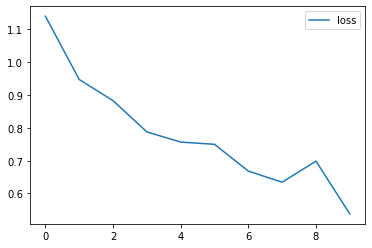

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'])
plt.legend(['loss'])
plt.show()

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 80%


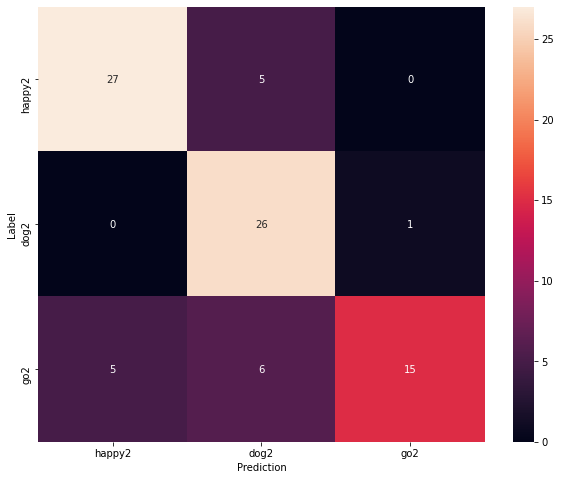

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# code credit
udemy:speech-recognition-a-z-with-hands-on-learnkarts

https://www.tensorflow.org/tutorials/audio/simple_audio
Nice Explanation:https://www.digikey.com/en/maker/projects/tensorflow-lite-tutorial-part-2-speech-recognition-model-training/d8d04a2b60a442cf8c3fa5c0dd2a292b


**Lecturor's version**



In [ ]:
#Q1. Read 'harvard.wav' and extract features for example, Zero Crossing Rate, spectral centroid from it?

In [ ]:
import librosa
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

import soundfile as sf
print("PySoundFile", sf.__version__)

In [ ]:
audio_path = 'harvard.wav'
x,sr = librosa.load(audio_path)

In [ ]:
# Zooming in and find Zero Crossing Rate
n0 = 9000
n1 = 9100
plt.figure(figsize=(18,6))
plt.plot(x[n0:n1])
plt.grid()

In [ ]:
zero_crossings = librosa.zero_crossings(x[n0:n1],pad = False)
print(sum(zero_crossings))

In [ ]:
#spectral centroid -- centre of mass -- weighted mean of the frequencies present in the sound


In [ ]:
spectral_centroids = librosa.feature.spectral_centroid(x,sr = sr)[0]
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
def normalize(x,axis = 0):
    return sklearn.preprocessing.minmax_scale(x,axis = axis)
plt.figure(figsize=(18,6))
librosa.display.waveplot(x,sr=sr,alpha = 0.4)
plt.plot(t,normalize(spectral_centroids),color = 'r')
plt.show()

In [ ]:
#Q2. Build a deep learning model for voice recognition? Use data in folder 'short-data2'?


In [ ]:
import os
import librosa

import numpy as np
from scipy.io  import wavfile
import warnings
import matplotlib.pyplot as plt
import IPython.display as ipd

In [ ]:
# Data Exploration and Visulization

train_audio_path='short-data2/'

In [ ]:
#Number of Audio for each file type


In [ ]:
labels  =os.listdir(train_audio_path)
print(labels)

In [ ]:
number_of_recordings  =[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path+label)if f.endswith('.wav')]
    number_of_recordings.append(len(waves))
print('No of Recordings', number_of_recordings)

In [ ]:
#Pre-proces the audio file


In [ ]:
train_audio_path = 'short-data2'
all_waves = []
all_label = []

for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path+'/' + label) if f.endswith('.wav')]
    #print(waves)
    for wave in waves:
        samples, sample_rate = librosa.load(train_audio_path+'/'+ label+'/'+wave, sr=16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)==8000):
            all_waves.append(samples)
            all_label.append(label)
            print('appen='+label)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
y=le.fit_transform(all_label)
classes = list(le.classes_)

from keras.utils import np_utils
print('y=', y)
y=np_utils.to_categorical(y, num_classes=len(labels))
all_waves =np.array(all_waves).reshape(-1,8000,1)
print('done')

In [ ]:
#split train and test
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_waves), np.array(y),stratify=y, test_size=0.2, random_state=7)

In [ ]:
#Model
from keras.layers import Dense, Dropout,Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf

In [ ]:
inputs = Input(shape=(8000,1))
print(inputs)

In [ ]:
conv =Conv1D(8,13,padding='valid', activation='relu', strides=1)(inputs)
conv =MaxPooling1D(3)(conv)
conv =Dropout(0.3)(conv)

conv=Flatten()(conv)
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs =Dense(len(labels), activation='softmax')(conv)
model =Model(inputs, outputs)

model.summary()

In [ ]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(x_tr, y_tr,  epochs = 25, validation_data = (x_val, y_val))